<a href="https://colab.research.google.com/github/masterhung0112/ml/blob/master/NN2LayerScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

np.set_printoptions(threshold=np.inf)
%matplotlib inline

![alt text](https://github.com/masterhung0112/ml/blob/master/NN2LayerScratch.jpeg?raw=true)

In [0]:
# non-linear activation function
def Sigmoid(Z):
  return 1/(1+np.exp(-Z))

# non-linear activation function
def Relu(Z):
  return np.maximum(0,Z)

# the derivatives of the Relu 
def dRelu(x):
  x[x<=0] = 0
  x[x>0] = 1
  return x

# the derivatives of the Sigmoid 
def dSigmoid(Z):
  s = 1/(1+np.exp(-Z))
  dZ = s * (1-s)
  return dZ

def plotCf(a,b,t):
  cf =confusion_matrix(a,b)
  plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
  plt.colorbar()
  plt.title(t)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  tick_marks = np.arange(len(set(a))) # length of classes
  class_labels = ['0','1']
  plt.xticks(tick_marks,class_labels)
  plt.yticks(tick_marks,class_labels)
  thresh = cf.max() / 2.
  for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
      plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
  plt.show();

 Class **dlnet** that setups and initializes our network.
- **X**: Holds the input layer, the data given to the network. X is a matrix that has as many rows as features and as many columns as samples we have available to train the network.
- **Y**: Holds the desired output.
- **Yh**: Holds the output that our network produces. It should have the same dimensions than **Y**, our desired target values. We initialize it to zero.
- **L**: It holds the number of layers of our network, 2.
- **dims**: Next, we define the number of neurons or units in each of our layers. We do this with a numpy array. The first component of the array is our input (which is not counted as a layer of the network). Our input will have 9 units because, as we will see in a bit, our data-set will have 9 useful features. Next, the first layer of the neural network will have 15 neurons, and our second and final layer will have 1 (the output of the network).
- **param**: A Python dictionary that will hold the W and b parameters of each of the layers of the network.
- **ch**: a cache variable, a python dictionary that will hold some intermediate calculations that we will need during the backward pass of the gradient descent algorithm.
- **lr**: Our learning rate. This sets the speed at which the network will learn.
- **sam**: The number of training samples we have.
- **loss**: An array where we will store the loss value of the network every x iterations. The loss value expresses the difference between the predicted output of our network and the target one.

The function **nInit**, which will initialize with random values the parameters of our network
- **W1**: The number of rows is the number of hidden units of that layer, dims[1], and the number of columns is the number of features/rows of the previous layer (in this case X, our input data), dims[0].
- **b1**: Same number of rows as W1 and a single column.
- **W2**: The number of rows is the number of hidden units of that layer, dims[2], and the number of columns is again the number of rows of the input to that layer, dims[1].
- **b2**: Same number of rows as W2 and a single column.

In [0]:
class dlnet:
  def __init__(self, x, y):
    self.X = x
    self.Y = y
    self.Yh = np.zeros((1, self.Y.shape[1]))
    
    self.L = 2
    self.dims = [9, 15, 1]
    
    self.param = {}
    self.ch = {}
    self.grad = {}
    
    self.loss = []
    self.lr = 0.003
    self.sam = self.Y.shape[1]
  
  # the function nInit, which will initialize with random values the parameters of our network
  def nInit(self):    
    np.random.seed(1)
    self.param['W1'] = np.random.randn(self.dims[1], self.dims[0]) / np.sqrt(self.dims[0]) 
    self.param['b1'] = np.zeros((self.dims[1], 1))        
    self.param['W2'] = np.random.randn(self.dims[2], self.dims[1]) / np.sqrt(self.dims[1]) 
    self.param['b2'] = np.zeros((self.dims[2], 1))                
    return
  
  # the Loss, the distance between Yh and Y
  # Cross-Entropy Loss Function
  def nloss(self,Yh):
      loss = (1./self.sam) * (-np.dot(self.Y, np.log(Yh).T) - np.dot(1-self.Y, np.log(1-Yh).T))    
      return loss
  
  # Take the input of the network and pass it forwards through 
  # its different layers until it produces an output
  #
  # Multiply the weights of the first layer by the input data and 
  # add the first bias matrix , b1, to produce Z1. 
  # We then apply the Relu function to Z1 to produce A1.
  #
  # Multiply the weight matrix of the second layer by its input, 
  # A1 (the soutput of the first layer, which is the input of the second layer),
  # and we add the second bias matrix, b2, in order to produce Z2. 
  # We then apply the Sigmoid function to Z2 to produce A2, 
  # which is in fact Yh, the output of the network.
  #
  # Ran our input data through the network and produced Yh, an output
  #
  # Z: represent the output of the computation of a layer
  # A: represent the output of the activation function
  def forward(self):    
    # Layer 1
    Z1 = self.param['W1'].dot(self.X) + self.param['b1'] 
    A1 = Relu(Z1)
    self.ch['Z1'], self.ch['A1'] = Z1, A1
    
    # Layer 2
    Z2 = self.param['W2'].dot(A1) + self.param['b2']  
    A2 = Sigmoid(Z2)
    self.ch['Z2'], self.ch['A2'] = Z2, A2
    self.Yh = A2
    loss = self.nloss(A2)
    
    return self.Yh, loss
  
  # dLoss_Yh = — (Y/Yh — (1-Y)/(1-Yh)) | Loss = -(Y Log Yh + (1-Y) Log (1-Yh))
  # dYh_Z2 = dSigmoid(Z2) | dSigmoid = sigmoid(x) * (1.0 — sigmoid(x)) | Yh = sigmoid (Z2)
  # dLoss_Z2 = dLoss_Yh * dSigmoid(Z2)
  # dLoss_A1 = W2 * dLoss_Z2 | dZ2_A1 = W2 | Z2 = W2 A1 + b2
  # dA1_Z1= dRelu (Z1) | A1 = Relu (Z1)
  # dLoss_Z1 = dLoss_A1 * dRelu (Z1)
  # dLoss_W1= X * dLoss_Z1 | dZ1_W1 = X | Z1 = W1 X+ b1
  #
  # dLoss_Yh = — (np.divide(self.Y, self.Yh ) — np.divide(1 — self.Y, 1 — self.Yh)) 
  # dLoss_Z2 = dLoss_Yh * dSigmoid(self.ch[‘Z2’]) 
  # dLoss_A1 = np.dot(self.param[“W2”].T, dLoss_Z2) 
  # dLoss_Z1 = dLoss_A1 * dRelu(self.ch[‘Z1’]) 
  # dLoss_W1 = 1./self.X.shape[1] * np.dot(dLoss_Z1, self.X.T)
  #
  def backward(self):
    dLoss_Yh = - (np.divide(self.Y, self.Yh) - np.divide(1 - self.Y, 1 - self.Yh))    
        
    dLoss_Z2 = dLoss_Yh * dSigmoid(self.ch['Z2'])    
    dLoss_A1 = np.dot(self.param["W2"].T, dLoss_Z2)
    dLoss_W2 = 1./self.ch['A1'].shape[1] * np.dot(dLoss_Z2, self.ch['A1'].T)
    dLoss_b2 = 1./self.ch['A1'].shape[1] * np.dot(dLoss_Z2, np.ones([dLoss_Z2.shape[1],1])) 
                        
    dLoss_Z1 = dLoss_A1 * dRelu(self.ch['Z1'])        
    dLoss_A0 = np.dot(self.param["W1"].T, dLoss_Z1)
    dLoss_W1 = 1./self.X.shape[1] * np.dot(dLoss_Z1, self.X.T)
    dLoss_b1 = 1./self.X.shape[1] * np.dot(dLoss_Z1, np.ones([dLoss_Z1.shape[1],1]))  
    
    # The learning rate is a parameter that allows us to set how fast the network learns. 
    # We, therefore, modify our weights and biases by a quantity proportional to that learning rate.
    self.param["W1"] = self.param["W1"] - self.lr * dLoss_W1
    self.param["b1"] = self.param["b1"] - self.lr * dLoss_b1
    self.param["W2"] = self.param["W2"] - self.lr * dLoss_W2
    self.param["b2"] = self.param["b2"] - self.lr * dLoss_b2
  
  def pred(self,x, y):  
    self.X=x
    self.Y=y
    comp = np.zeros((1,x.shape[1]))
    pred, loss = self.forward()    
    
    for i in range(0, pred.shape[1]):
      if pred[0,i] > 0.5: comp[0,i] = 1
      else: comp[0,i] = 0
    
    print("Acc: " + str(np.sum((comp == y)/x.shape[1])))
    
    return comp
      
  def gd(self, X, Y, iter = 3000):
    np.random.seed(1)                         

    self.nInit()

    for i in range(0, iter):
      Yh, loss = self.forward()
      self.backward()
        
      if i % 500 == 0:
        print ("Cost after iteration %i: %f" % (i, loss))
        self.loss.append(loss)
    
    plt.plot(np.squeeze(self.loss))
    plt.ylabel('Loss')
    plt.xlabel('Iter')
    plt.title("Lr = " + str(self.lr))
    plt.show()
    
    return

Our objective will be to train our neural network to predict if a tumor is benign or malignant

- Store the data in .csv format in your machine or online
- Read the data using Pandas read_csv function
- Then we proceed to clean and prepare the data, build our datasets and run gradient descent.
- The benign and malignant classes are identified with the digits 2 and 4. 

**CSV**
- There are 699 rows in total, belonging to 699 patients
- The first column is an ID that identifies each patient.
- The following 9 columns are features that express different types of information connected to the detected tumors. They represent data related to: Clump Thickness, Uniformity of Cell Size, Uniformity of Cell Shape, Marginal Adhesion, Single Epithelial Cell Size, Bare Nuclei, Bland Chromatin, Normal Nucleoli and Mitoses.
- The last column is the class of the tumor and it has two possible values: 2 means that the tumor was found to be benign. 4 means that it was found to be malignant.
- There are a few rows that contain missing data. The missing data is represented in the data-set with the ? character.
- Out of the 699 patients in the dataset, the class distribution is: Benign: 458 (65.5%) and Malignant: 241 (34.5%)

Normalized Data:
![alt text](https://github.com/masterhung0112/ml/blob/master/NN2LayerScratch_NormalizedData.jpeg?raw=true)

(683, 11) (9, 500) (1, 500) (9, 182) (1, 182)
Cost after iteration 0: 0.673967
Cost after iteration 500: 0.122093
Cost after iteration 1000: 0.108469
Cost after iteration 1500: 0.103673
Cost after iteration 2000: 0.100911
Cost after iteration 2500: 0.099047
Cost after iteration 3000: 0.097530
Cost after iteration 3500: 0.096368
Cost after iteration 4000: 0.095480
Cost after iteration 4500: 0.094744
Cost after iteration 5000: 0.094015
Cost after iteration 5500: 0.093277
Cost after iteration 6000: 0.092611
Cost after iteration 6500: 0.091953
Cost after iteration 7000: 0.091279
Cost after iteration 7500: 0.090472
Cost after iteration 8000: 0.089574
Cost after iteration 8500: 0.088575
Cost after iteration 9000: 0.087426
Cost after iteration 9500: 0.086303
Cost after iteration 10000: 0.085122
Cost after iteration 10500: 0.084010
Cost after iteration 11000: 0.083025
Cost after iteration 11500: 0.082001
Cost after iteration 12000: 0.080948
Cost after iteration 12500: 0.079923
Cost after itera

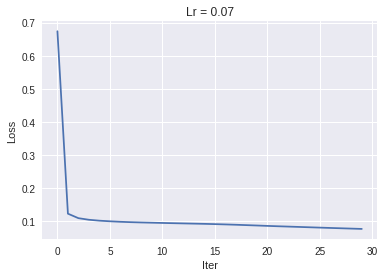

In [7]:
if __name__ == "__main__":
  data_url = 'https://raw.githubusercontent.com/masterhung0112/ml/master/NN2LayerScratch-wisconsin-cancer-dataset.csv'
  df = pd.read_csv(data_url, header=None)
  
  # eliminate all rows that hold missing values (represented by the ? character) at column 6
  df = df[~df[6].isin(['?'])]
  
  # The ‘?’ character causes Python to interpret column 6 as made of strings. 
  # Other columns are made of integers. 
  # We set the entire dataframe to be interpreted as made of float numbers.
  df = df.astype(float)
  
  # change the class values (at the column number 10) from 2 to 0 and from 4 to 1
  df.iloc[:,10].replace(2, 0,inplace=True)
  df.iloc[:,10].replace(4, 1,inplace=True)

  df.head(3)
  # scaled_df dataframe contains all the normalized columns, 
  # and we will pick the class column from 
  # the df dataframe, the non-normalized version of the data-set
  scaled_df=df
  
  # data normalization
  # new_x = (x - min_x) / (max_x - min_x)
  names = df.columns[0:10]
  scaler = MinMaxScaler() 
  scaled_df = scaler.fit_transform(df.iloc[:,0:10]) 
  scaled_df = pd.DataFrame(scaled_df, columns=names)
  
  x = scaled_df.iloc[0:500,1:10].values.transpose()
  y = df.iloc[0:500,10:].values.transpose()

  xval = scaled_df.iloc[501:683,1:10].values.transpose()
  yval = df.iloc[501:683,10:].values.transpose()

  print(df.shape, x.shape, y.shape, xval.shape, yval.shape)

  nn = dlnet(x,y)
  nn.lr = 0.07
  nn.dims = [9, 15, 1]
  nn.gd(x, y, iter = 15000)

In [9]:
pred_train = nn.pred(x, y)
pred_test = nn.pred(xval, yval)

Acc: 0.9700000000000003
Acc: 1.0


Acc: 0.9700000000000003


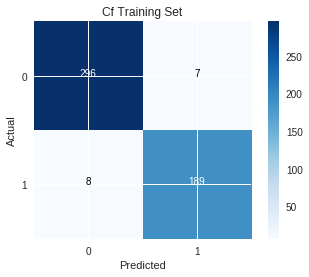

Acc: 1.0


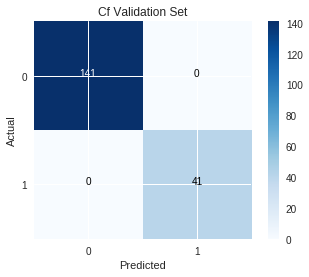

In [13]:
nn.threshold = 0.5

nn.X, nn.Y = x, y
target = np.around(np.squeeze(y), decimals = 0).astype(np.int)
predicted = np.around(np.squeeze(nn.pred(x, y)), decimals = 0).astype(np.int)
plotCf(target, predicted, 'Cf Training Set')

nn.X, nn.Y = xval, yval
target = np.around(np.squeeze(yval), decimals = 0).astype(np.int)
predicted = np.around(np.squeeze(nn.pred(xval, yval)), decimals = 0).astype(np.int)
plotCf(target, predicted, 'Cf Validation Set')

Acc: 0.9700000000000003


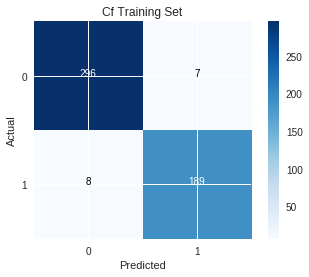

Acc: 1.0


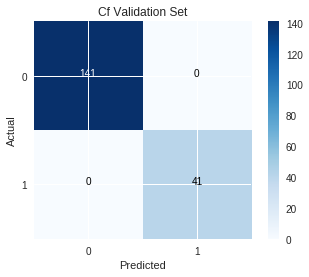

In [14]:
nn.threshold = 0.7

nn.X, nn.Y = x, y
target = np.around(np.squeeze(y), decimals = 0).astype(np.int)
predicted = np.around(np.squeeze(nn.pred(x, y)), decimals = 0).astype(np.int)
plotCf(target, predicted, 'Cf Training Set')

nn.X, nn.Y = xval, yval
target = np.around(np.squeeze(yval), decimals = 0).astype(np.int)
predicted = np.around(np.squeeze(nn.pred(xval, yval)), decimals = 0).astype(np.int)
plotCf(target, predicted, 'Cf Validation Set')

Acc: 0.9700000000000003


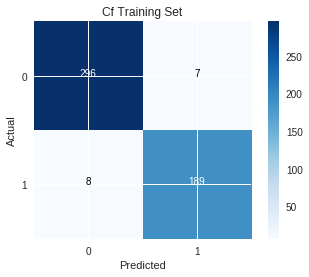

Acc: 1.0


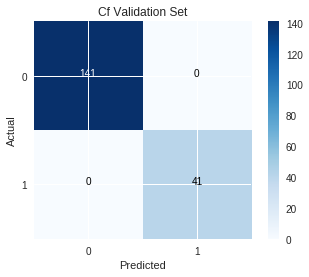

In [15]:
nn.threshold = 0.9

nn.X, nn.Y = x, y
target = np.around(np.squeeze(y), decimals = 0).astype(np.int)
predicted = np.around(np.squeeze(nn.pred(x, y)), decimals = 0).astype(np.int)
plotCf(target, predicted, 'Cf Training Set')

nn.X, nn.Y = xval, yval
target = np.around(np.squeeze(yval), decimals = 0).astype(np.int)
predicted = np.around(np.squeeze(nn.pred(xval, yval)), decimals = 0).astype(np.int)
plotCf(target, predicted, 'Cf Validation Set')

In [17]:
nn.X,nn.Y = xval, yval 
yvalh, loss = nn.forward()
print("\ny ",np.around(yval[:,0:50,], decimals=0).astype(np.int))       
print("\nyh",np.around(yvalh[:,0:50,], decimals=0).astype(np.int),"\n")


y  [[0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 1]]

yh [[0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 1]] 

